In [2]:
# import sys
# 
# from tests.smoke_tests.olesik_et_al_2022.test_simulation import settings
# 
# if 'google.colab' in sys.modules:
#     !pip --quiet install open-atmos-jupyter-utils
#     from open_atmos_jupyter_utils import pip_install_on_colab
#     pip_install_on_colab('PyMPDATA-examples')

In [1]:
# import os
# os.environ["NUMBA_DISABLE_JIT"] = "1"

from asian_option import AsianArithmetic, Settings, plot_solution, plot_difference_arithmetic

import numpy as np
from matplotlib import pyplot
from ipywidgets import IntProgress
from tqdm import tqdm

from open_atmos_jupyter_utils import show_plot, show_anim
from monte_carlo import BSModel, FixedStrikeGeometricAsianOption, FixedStrikeArithmeticAsianOption
import time

In [2]:
def run_numeric_and_mc(params, nx=31, ny=41, nt=300):
    s_max = params.get('S_max', params['spot']*2)
    s_min = params.get('S_min', params['spot']/2)
    settings = Settings(T=params['T'], K=params['K'], r=params['r'], sgma=params['sgma'], S_max=s_max, S_min=s_min)
    simulation = AsianArithmetic(settings, nx=nx, ny=ny, nt=nt)
    
    
    history = []
    progbar = IntProgress(max = simulation.nt)
    display(progbar)
    start = time.time()
    for progbar.value in range(simulation.nt + 1):
        if progbar.value != 0:
            res = simulation.step()
        history.append(simulation.solver.advectee.get().copy())
    end = time.time()
    print(f"MPDATA elapsed time: {end - start}")
    print(f"Numeric price: {np.interp(params['spot'], simulation.S, history[-1][:,0])}")
    start = time.time()
    arithmetic_by_mc = np.zeros_like(simulation.S)
    for idx, spot in tqdm(enumerate(simulation.S)):
        model = BSModel(spot, settings.params.r, settings.params.sgma, settings.params.T, 1000)
        arithmetic_option = FixedStrikeArithmeticAsianOption(settings.params.T, settings.params.K, 'call', model,  100000)
        arithmetic_by_mc[idx] = arithmetic_option.price_by_mc()
    end = time.time()
    print(f"MC elapsed time: {end - start}")
    _, ax = pyplot.subplots(1, 1, figsize=(10, 5))
    plot_solution(settings=settings,
                  frame_index=-1,
                  ax=ax,
                  history=history,
                  arithmetic_by_mc=arithmetic_by_mc,
                  S_linspace=simulation.S,
                  option_type='arithmetic call')
    show_plot('numeric_vs_analytic.pdf')
    _, ax = pyplot.subplots(1, 1, figsize=(10, 5))
    plot_difference_arithmetic(settings=settings,
                  frame_index=-1,
                  ax=ax,
                  history=history,
                  arithmetic_by_mc=arithmetic_by_mc,
                  S_linspace=simulation.S,
                  option_type='arithmetic call')
    show_plot('numeric_vs_analytic_error.pdf')
    
    print(f"True price: {params['true_price']}")
    print(f"Numeric price: {np.interp(params['spot'], simulation.S, history[-1][:,0])}")
    print(f"MC price: {np.interp(params['spot'], simulation.S, arithmetic_by_mc)}")

## sigma = 0.1

### T = 0.25

self.l2=np.float64(6.737324795840403)
CFL 0.33739169305000277
courant_x=np.float64(0.004725026383336177), courant_y=np.float64(0.3326666666666666)
x_dim_advector.shape=(122, 500), self.a_dim_advector.shape=(121, 501)


IntProgress(value=0, max=1500)

MPDATA elapsed time: 58.98099613189697
Numeric price: 6.117620067942513


121it [04:22,  2.17s/it]

MC elapsed time: 262.8348124027252


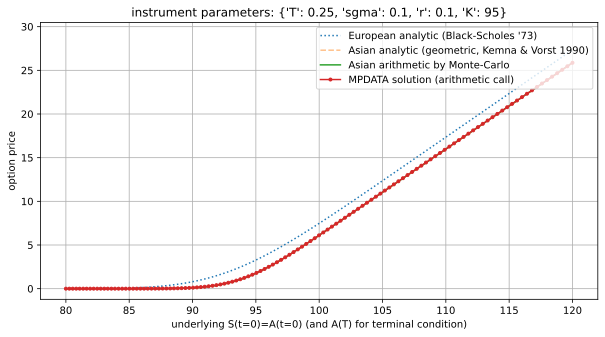

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:395: RuntimeWarning: divide by zero encountered in divide
  abs(arithmetic_by_mc - history[frame_index][:, 0]) / arithmetic_by_mc,
/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:404: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


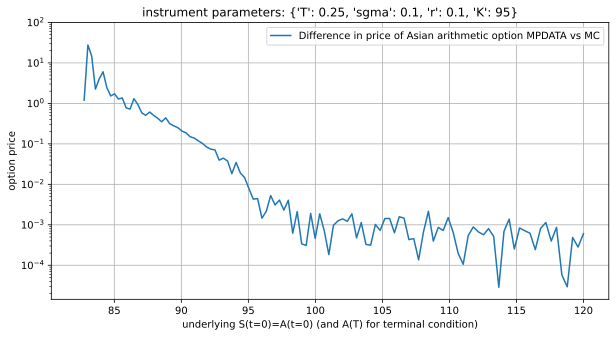

True price: 6.132
Numeric price: 6.117620067942513
MC price: 6.1208107318861265


In [5]:
params = {
        'T': 0.25,
        'K': 95,
        'r': 0.1,
        'sgma': 0.1,
        'spot': 100,
        'true_price': 6.132,
        'S_max': 120,
        'S_min': 80
    }
run_numeric_and_mc(params, nx=121, ny=500, nt=1500)

self.l2=np.float64(9.66975515497494)
CFL 0.3366106969535836
courant_x=np.float64(0.003944030286916974), courant_y=np.float64(0.3326666666666666)
x_dim_advector.shape=(102, 500), self.a_dim_advector.shape=(101, 501)


IntProgress(value=0, max=1500)

MPDATA elapsed time: 65.01133799552917
Numeric price: 1.873875070498296


101it [03:25,  2.04s/it]

MC elapsed time: 205.91771578788757


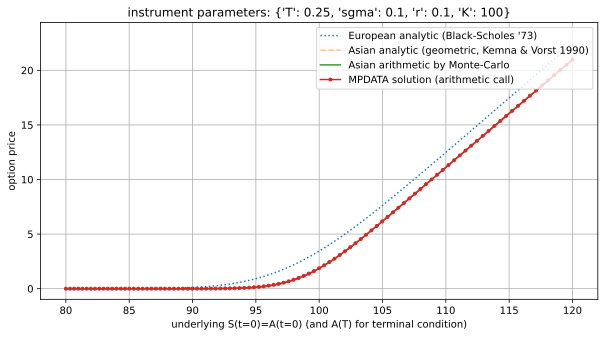

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:395: RuntimeWarning: divide by zero encountered in divide
  abs(arithmetic_by_mc - history[frame_index][:, 0]) / arithmetic_by_mc,
/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:404: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


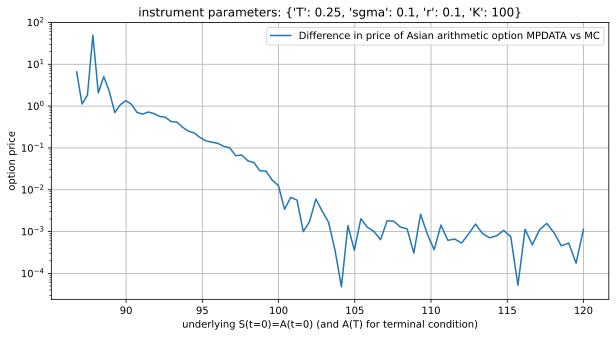

True price: 1.869
Numeric price: 1.873875070498296
MC price: 1.8510434244370215


In [37]:
params = {
        'T': 0.25,
        'K': 100,
        'r': 0.1,
        'sgma': 0.1,
        'spot': 100,
        'true_price': 1.869,
        'S_max': 120,
        'S_min': 80
    }
run_numeric_and_mc(params, nx=101, ny=500, nt=1500)

self.l2=np.float64(9.66975515497494)
CFL 0.3366106969535836
courant_x=np.float64(0.003944030286916974), courant_y=np.float64(0.3326666666666666)
x_dim_advector.shape=(102, 500), self.a_dim_advector.shape=(101, 501)


IntProgress(value=0, max=1500)

MPDATA elapsed time: 6.592661142349243
Numeric price: 0.17248245918828978


101it [03:21,  2.00s/it]

MC elapsed time: 201.8002269268036


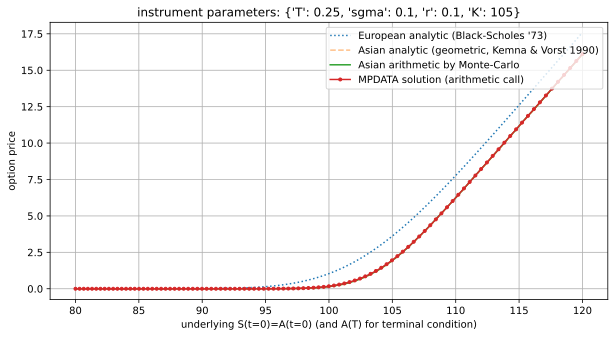

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:395: RuntimeWarning: divide by zero encountered in divide
  abs(arithmetic_by_mc - history[frame_index][:, 0]) / arithmetic_by_mc,
/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:404: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


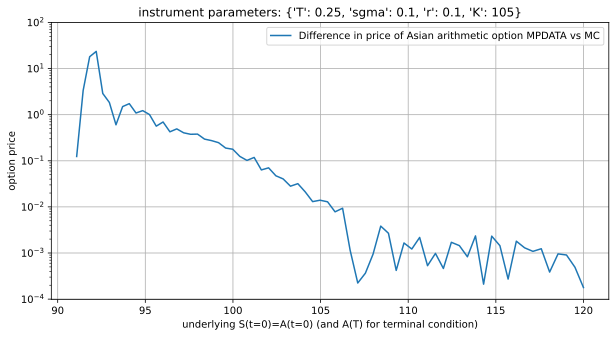

True price: 0.151
Numeric price: 0.17248245918828978
MC price: 0.14671374756013328


In [45]:
params = {
        'T': 0.25,
        'K': 105,
        'r': 0.1,
        'sgma': 0.1,
        'spot': 100,
        'true_price': 0.151,
        'S_max': 120,
        'S_min': 80
    }
run_numeric_and_mc(params, nx=101, ny=500, nt=1500)

### T = 0.5

self.l2=np.float64(4.83487757748747)
CFL 0.34055472724050057
courant_x=np.float64(0.007888060573833948), courant_y=np.float64(0.3326666666666666)
x_dim_advector.shape=(102, 500), self.a_dim_advector.shape=(101, 501)


IntProgress(value=0, max=1500)

MPDATA elapsed time: 36.11634802818298
Numeric price: 7.23805467438877


101it [04:12,  2.50s/it]

MC elapsed time: 252.5069715976715


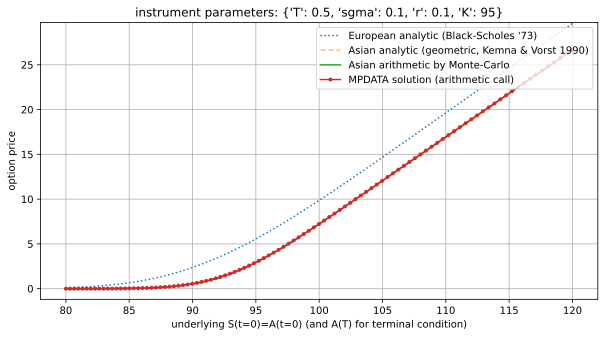

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:404: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


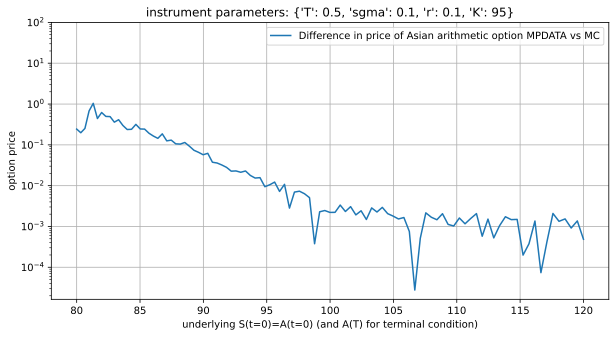

True price: 7.248
Numeric price: 7.23805467438877
MC price: 7.223247309952393


In [46]:
params = {
        'T': 0.5,
        'K': 95,
        'r': 0.1,
        'sgma': 0.1,
        'spot': 100,
        'true_price': 7.248,
        'S_max': 120,
        'S_min': 80
    }
run_numeric_and_mc(params, nx=101, ny=500, nt=1500)

self.l2=np.float64(9.783889340993785)
CFL 0.2715450722845763
courant_x=np.float64(0.0055450722845763415), courant_y=np.float64(0.26599999999999996)
x_dim_advector.shape=(72, 400), self.a_dim_advector.shape=(71, 401)


IntProgress(value=0, max=1500)

MPDATA elapsed time: 35.576953411102295
Numeric price: 3.1170989026076468


71it [02:51,  2.41s/it]

MC elapsed time: 171.40877079963684


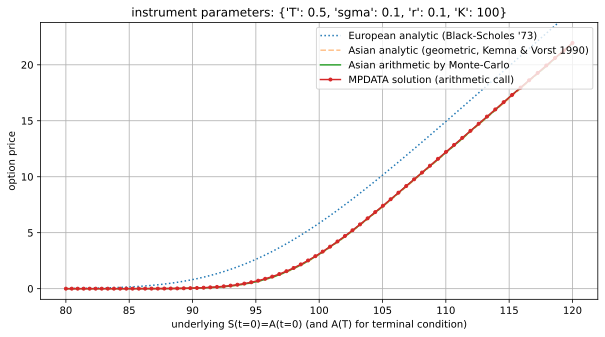

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:395: RuntimeWarning: divide by zero encountered in divide
  abs(arithmetic_by_mc - history[frame_index][:, 0]) / arithmetic_by_mc,
/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:404: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


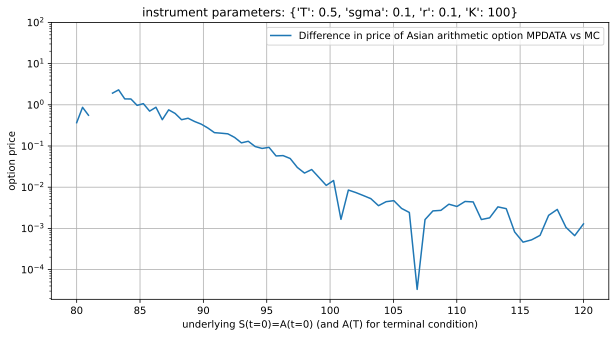

True price: 3.1
Numeric price: 3.1170989026076468
MC price: 3.0771666777085724


In [50]:
params = {
        'T': 0.5,
        'K': 100,
        'r': 0.1,
        'sgma': 0.1,
        'spot': 100,
        'true_price': 3.1,
        'S_max': 120,
        'S_min': 80
    }
run_numeric_and_mc(params, nx=71, ny=400, nt=1500)

self.l2=np.float64(6.44650343664996)
CFL 0.20541604543037542
courant_x=np.float64(0.005916045430375462), courant_y=np.float64(0.19949999999999996)
x_dim_advector.shape=(102, 400), self.a_dim_advector.shape=(101, 401)


IntProgress(value=0, max=2000)

MPDATA elapsed time: 51.17937707901001
Numeric price: 0.755516576533361


101it [03:25,  2.03s/it]

MC elapsed time: 205.32445168495178


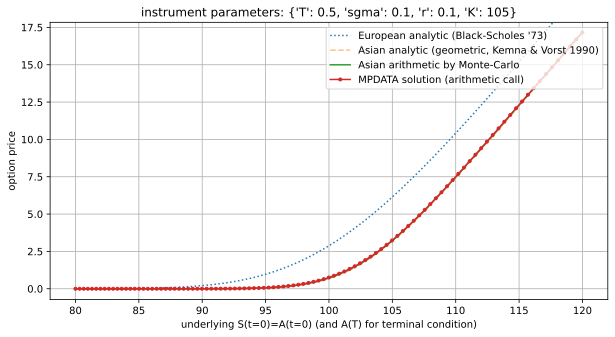

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:395: RuntimeWarning: divide by zero encountered in divide
  abs(arithmetic_by_mc - history[frame_index][:, 0]) / arithmetic_by_mc,
/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:404: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


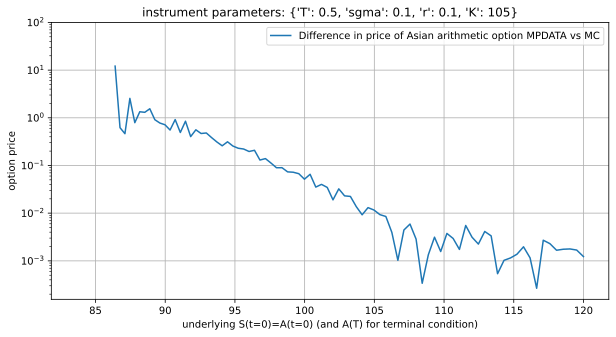

True price: 0.727
Numeric price: 0.755516576533361
MC price: 0.7181102171339728


In [7]:
params = {
        'T': 0.5,
        'K': 105,
        'r': 0.1,
        'sgma': 0.1,
        'spot': 100,
        'true_price': 0.727,
        'S_max': 120,
        'S_min': 80
    }
run_numeric_and_mc(params, nx=101, ny=400, nt=2000)

### T = 1

self.l2=np.float64(47.0986191469661)
CFL 0.20236853178346584
courant_x=np.float64(0.0027685317834659213), courant_y=np.float64(0.19959999999999992)
x_dim_advector.shape=(102, 500), self.a_dim_advector.shape=(101, 501)


IntProgress(value=0, max=2500)

MPDATA elapsed time: 40.146838903427124
Numeric price: 9.32109221064491


101it [03:22,  2.00s/it]

MC elapsed time: 202.10721015930176


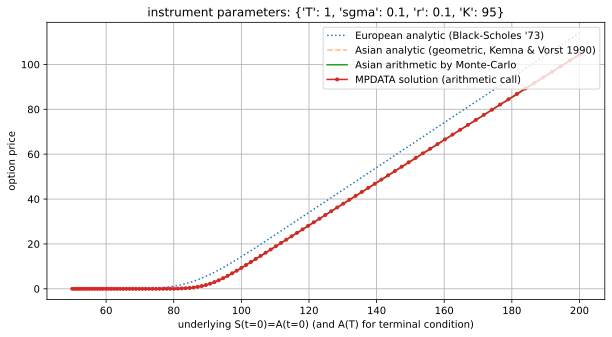

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:395: RuntimeWarning: divide by zero encountered in divide
  abs(arithmetic_by_mc - history[frame_index][:, 0]) / arithmetic_by_mc,
/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:404: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


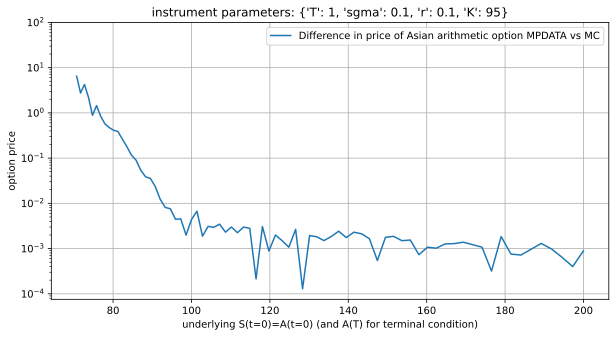

True price: 9.313
Numeric price: 9.32109221064491
MC price: 9.280451262059675


In [63]:
params = {
        'T': 1,
        'K': 95,
        'r': 0.1,
        'sgma': 0.1,
        'spot': 100,
        'true_price': 9.313,
    }
run_numeric_and_mc(params, nx=101, ny=500, nt=2500)

self.l2=np.float64(47.0986191469661)
CFL 0.20236853178346584
courant_x=np.float64(0.0027685317834659213), courant_y=np.float64(0.19959999999999992)
x_dim_advector.shape=(102, 500), self.a_dim_advector.shape=(101, 501)


IntProgress(value=0, max=2500)

MPDATA elapsed time: 40.21532130241394
Numeric price: 5.291606873926925


101it [03:22,  2.01s/it]

MC elapsed time: 202.9929702281952


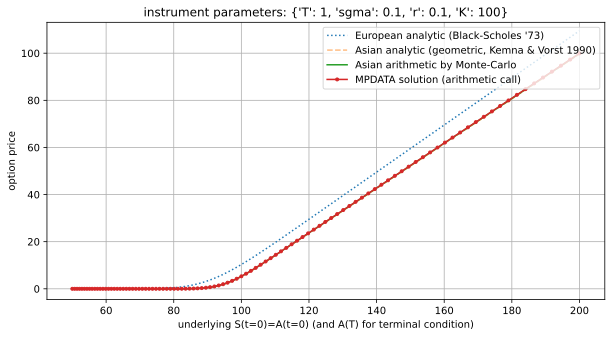

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:395: RuntimeWarning: divide by zero encountered in divide
  abs(arithmetic_by_mc - history[frame_index][:, 0]) / arithmetic_by_mc,
/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:404: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


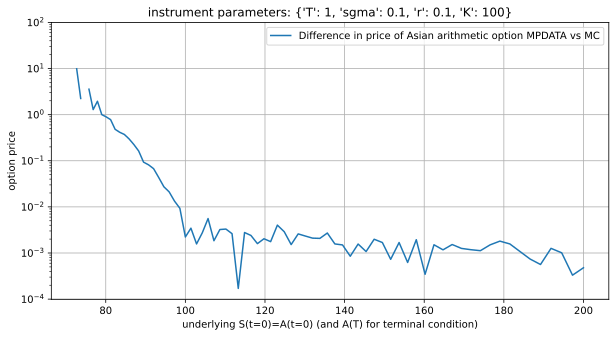

True price: 5.279
Numeric price: 5.291606873926925
MC price: 5.279868482000612


In [64]:
params = {
        'T': 1,
        'K': 100,
        'r': 0.1,
        'sgma': 0.1,
        'spot': 100,
        'true_price': 5.279,
    }
run_numeric_and_mc(params, nx=101, ny=500, nt=2500)

self.l2=np.float64(19.716959635506356)
CFL 0.20357276348987344
courant_x=np.float64(0.0039060968232068694), courant_y=np.float64(0.19966666666666658)
x_dim_advector.shape=(172, 600), self.a_dim_advector.shape=(171, 601)


IntProgress(value=0, max=3000)

MPDATA elapsed time: 42.432754039764404
Numeric price: 2.329833876655385


171it [07:08,  2.50s/it]

MC elapsed time: 428.2790036201477


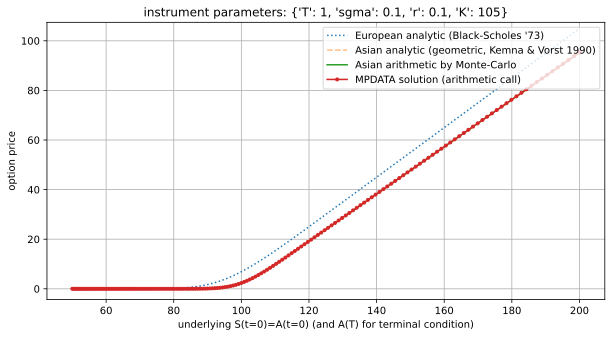

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:395: RuntimeWarning: divide by zero encountered in divide
  abs(arithmetic_by_mc - history[frame_index][:, 0]) / arithmetic_by_mc,
/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:404: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


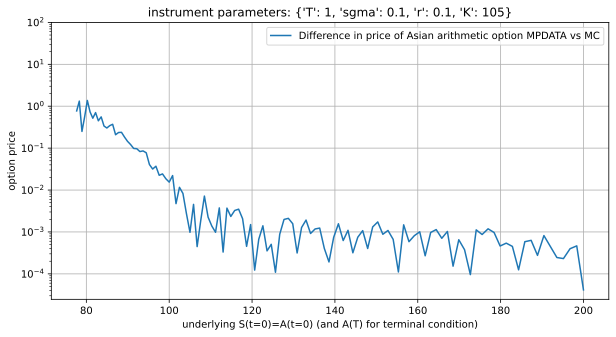

True price: 2.313
Numeric price: 2.329833876655385
MC price: 2.294358605447854


In [73]:
params = {
        'T': 1,
        'K': 105,
        'r': 0.1,
        'sgma': 0.1,
        'spot': 100,
        'true_price': 2.313,
    }
run_numeric_and_mc(params, nx=171, ny=600, nt=3000)

## sigma = 0.2

### T = 0.25

self.l2=np.float64(56.51834297635932)
CFL 0.16681904066376588
courant_x=np.float64(0.0004857073304326177), courant_y=np.float64(0.16633333333333325)
x_dim_advector.shape=(102, 500), self.a_dim_advector.shape=(101, 501)


IntProgress(value=0, max=3000)

MPDATA elapsed time: 44.36493515968323
Numeric price: 6.479734092585453


101it [04:14,  2.52s/it]

MC elapsed time: 254.65015649795532


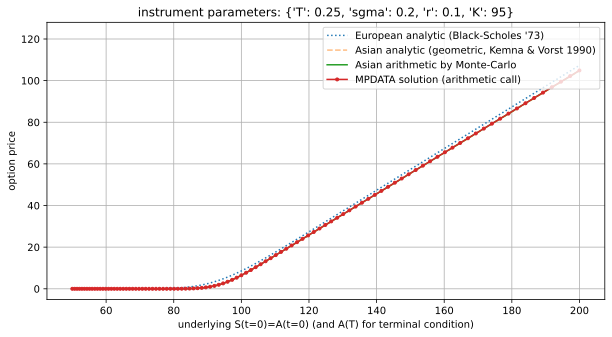

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:395: RuntimeWarning: divide by zero encountered in divide
  abs(arithmetic_by_mc - history[frame_index][:, 0]) / arithmetic_by_mc,
/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:404: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


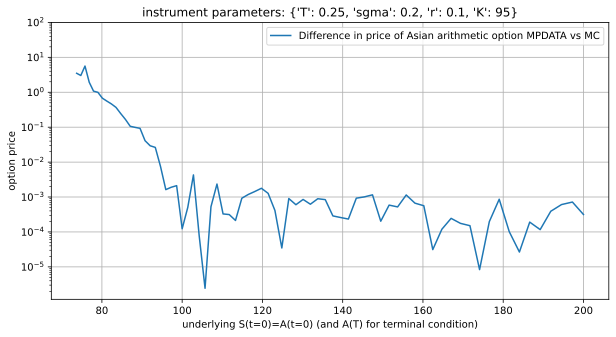

True price: 6.5
Numeric price: 6.479734092585453
MC price: 6.480534273237569


In [76]:
params = {
        'T': 0.25,
        'K': 95,
        'r': 0.1,
        'sgma': 0.2,
        'spot': 100,
        'true_price': 6.5,
    }
run_numeric_and_mc(params, nx=101, ny=500, nt=3000)

self.l2=np.float64(56.51834297635932)
CFL 0.16681904066376588
courant_x=np.float64(0.0004857073304326177), courant_y=np.float64(0.16633333333333325)
x_dim_advector.shape=(102, 500), self.a_dim_advector.shape=(101, 501)


IntProgress(value=0, max=3000)

MPDATA elapsed time: 41.78067398071289
Numeric price: 2.9615616957809614


101it [03:22,  2.00s/it]

MC elapsed time: 202.21847438812256


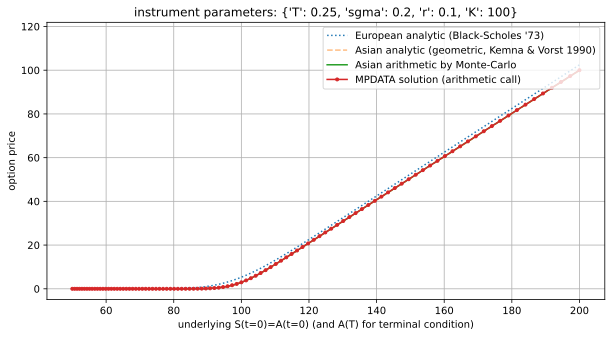

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:395: RuntimeWarning: divide by zero encountered in divide
  abs(arithmetic_by_mc - history[frame_index][:, 0]) / arithmetic_by_mc,
/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:404: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


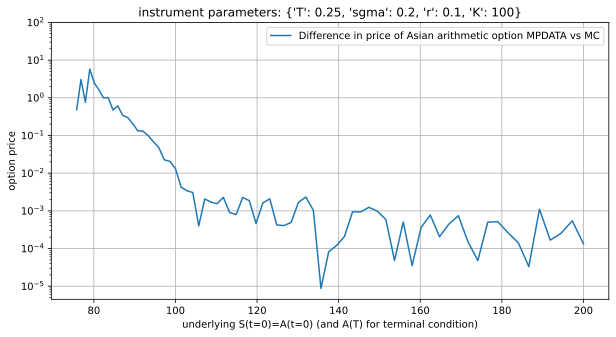

True price: 2.96
Numeric price: 2.9615616957809614
MC price: 2.9230179830439713


In [77]:
params = {
        'T': 0.25,
        'K': 100,
        'r': 0.1,
        'sgma': 0.2,
        'spot': 100,
        'true_price': 2.960,
    }
run_numeric_and_mc(params, nx=101, ny=500, nt=3000)

self.l2=np.float64(25.285891702199095)
CFL 0.2670594898372473
courant_x=np.float64(0.0007261565039141117), courant_y=np.float64(0.2663333333333332)
x_dim_advector.shape=(152, 800), self.a_dim_advector.shape=(151, 801)


IntProgress(value=0, max=3000)

MPDATA elapsed time: 67.22992396354675
Numeric price: 0.9735837467209867


151it [05:08,  2.04s/it]

MC elapsed time: 308.73529076576233


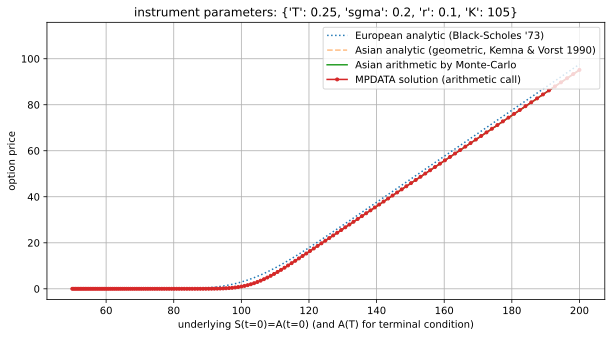

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:395: RuntimeWarning: divide by zero encountered in divide
  abs(arithmetic_by_mc - history[frame_index][:, 0]) / arithmetic_by_mc,
/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:404: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


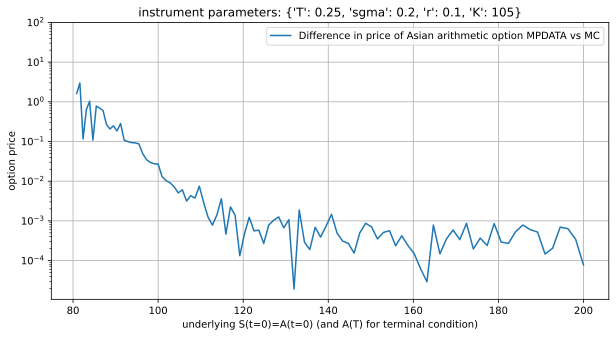

True price: 0.966
Numeric price: 0.9735837467209867
MC price: 0.9479796324019648


In [23]:
params = {
        'T': 0.25,
        'K': 105,
        'r': 0.1,
        'sgma': 0.2,
        'spot': 100,
        'true_price': 0.966,
    }
run_numeric_and_mc(params, nx=151, ny=800, nt=3000)

### T = 0.5

self.l2=np.float64(28.25917148817966)
CFL 0.10063808132753185
courant_x=np.float64(0.0009714146608652355), courant_y=np.float64(0.09966666666666661)
x_dim_advector.shape=(102, 300), self.a_dim_advector.shape=(101, 301)


IntProgress(value=0, max=3000)

MPDATA elapsed time: 43.361796855926514
Numeric price: 7.907266869619778


101it [03:28,  2.07s/it]

MC elapsed time: 208.6245617866516


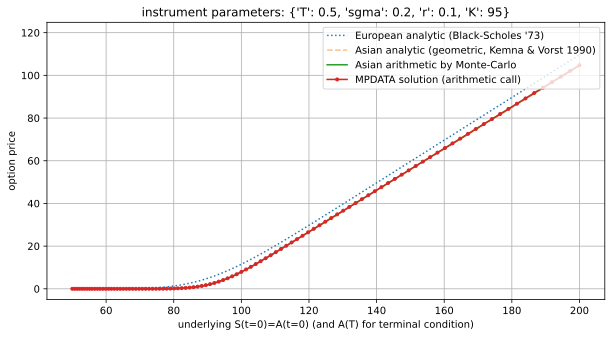

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:395: RuntimeWarning: divide by zero encountered in divide
  abs(arithmetic_by_mc - history[frame_index][:, 0]) / arithmetic_by_mc,
/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:404: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


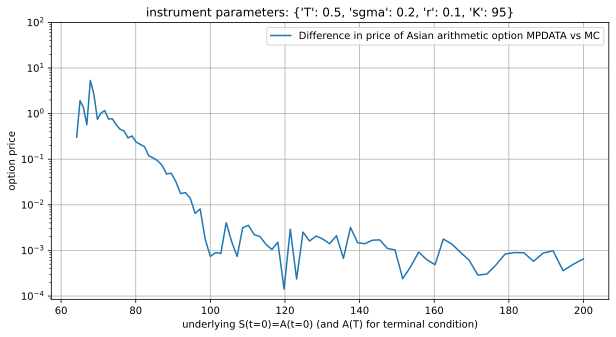

True price: 7.793
Numeric price: 7.907266869619778
MC price: 7.901410364533869


In [25]:
params = {
        'T': 0.5,
        'K': 95,
        'r': 0.1,
        'sgma': 0.2,
        'spot': 100,
        'true_price': 7.793,
    }
run_numeric_and_mc(params, nx=101, ny=300, nt=3000)

self.l2=np.float64(28.25917148817966)
CFL 0.10063808132753185
courant_x=np.float64(0.0009714146608652355), courant_y=np.float64(0.09966666666666661)
x_dim_advector.shape=(102, 300), self.a_dim_advector.shape=(101, 301)


IntProgress(value=0, max=3000)

MPDATA elapsed time: 64.4211094379425
Numeric price: 4.548534262410401


101it [03:28,  2.06s/it]

MC elapsed time: 208.44248747825623


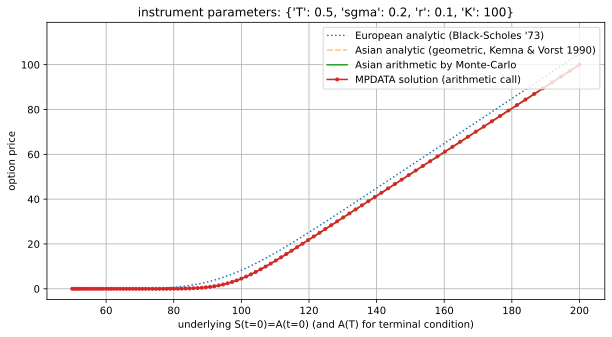

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:395: RuntimeWarning: divide by zero encountered in divide
  abs(arithmetic_by_mc - history[frame_index][:, 0]) / arithmetic_by_mc,
/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:404: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


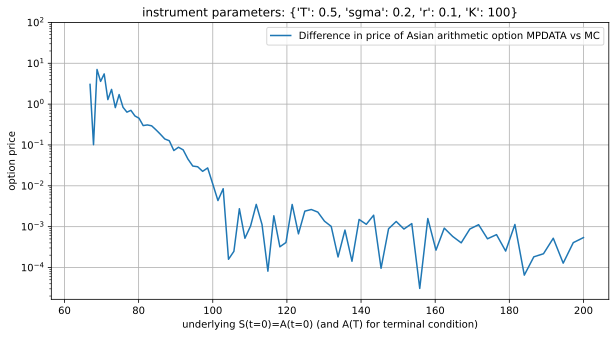

True price: 4.548
Numeric price: 4.548534262410401
MC price: 4.498795084403486


In [26]:
params = {
        'T': 0.5,
        'K': 100,
        'r': 0.1,
        'sgma': 0.2,
        'spot': 100,
        'true_price': 4.548,
    }
run_numeric_and_mc(params, nx=101, ny=300, nt=3000)

self.l2=np.float64(28.25917148817966)
CFL 0.13397141466086518
courant_x=np.float64(0.0009714146608652355), courant_y=np.float64(0.13299999999999995)
x_dim_advector.shape=(102, 400), self.a_dim_advector.shape=(101, 401)


IntProgress(value=0, max=3000)

MPDATA elapsed time: 19.9363956451416
Numeric price: 2.262972517589888


101it [03:22,  2.01s/it]

MC elapsed time: 202.7743284702301


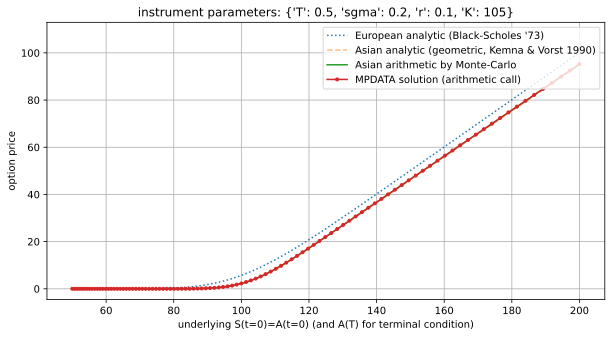

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:395: RuntimeWarning: divide by zero encountered in divide
  abs(arithmetic_by_mc - history[frame_index][:, 0]) / arithmetic_by_mc,
/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:404: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


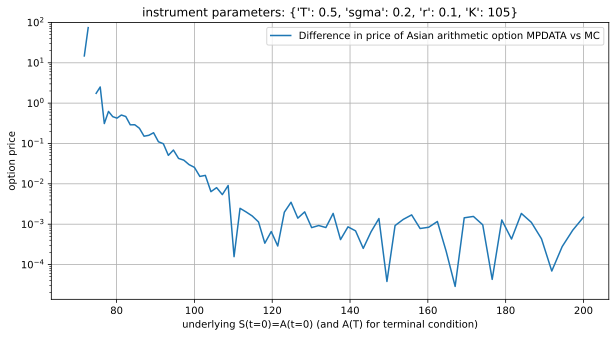

True price: 2.241
Numeric price: 2.262972517589888
MC price: 2.2065165941301417


In [30]:
params = {
        'T': 0.5,
        'K': 105,
        'r': 0.1,
        'sgma': 0.2,
        'spot': 100,
        'true_price': 2.241,
    }
run_numeric_and_mc(params, nx=101, ny=400, nt=3000)

### T = 1

self.l2=np.float64(14.12958574408983)
CFL 0.10160949598839708
courant_x=np.float64(0.001942829321730471), courant_y=np.float64(0.09966666666666661)
x_dim_advector.shape=(102, 300), self.a_dim_advector.shape=(101, 301)


IntProgress(value=0, max=3000)

MPDATA elapsed time: 11.284118890762329
Numeric price: 10.35798495255406


101it [03:22,  2.00s/it]

MC elapsed time: 202.11466360092163


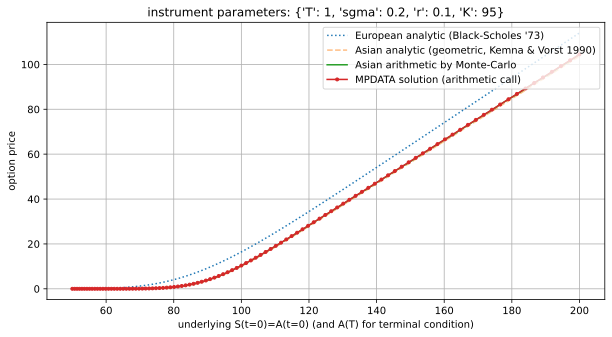

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:395: RuntimeWarning: divide by zero encountered in divide
  abs(arithmetic_by_mc - history[frame_index][:, 0]) / arithmetic_by_mc,
/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:404: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


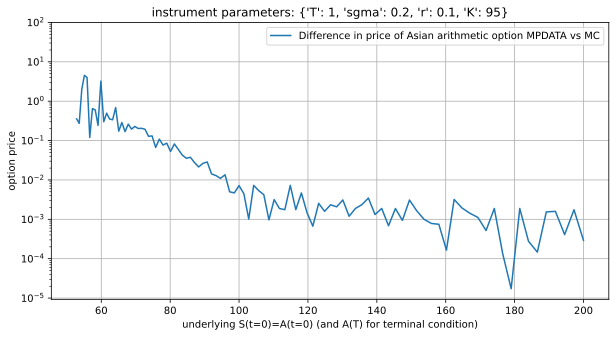

True price: 10.336
Numeric price: 10.35798495255406
MC price: 10.284173062381173


In [34]:
params = {
        'T': 1,
        'K': 95,
        'r': 0.1,
        'sgma': 0.2,
        'spot': 100,
        'true_price': 10.336,
    }
run_numeric_and_mc(params, nx=101, ny=300, nt=3000)

self.l2=np.float64(13.12623492707332)
CFL 0.051495660999475626
courant_x=np.float64(0.0017456609994756461), courant_y=np.float64(0.04974999999999998)
x_dim_advector.shape=(122, 200), self.a_dim_advector.shape=(121, 201)


IntProgress(value=0, max=4000)

MPDATA elapsed time: 60.90426731109619
Numeric price: 7.096975058351778


121it [04:08,  2.06s/it]

MC elapsed time: 248.98864316940308


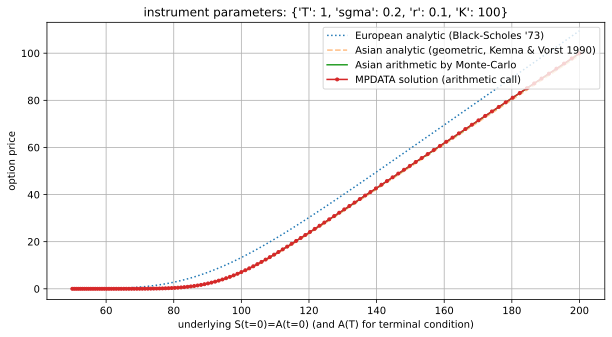

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:395: RuntimeWarning: divide by zero encountered in divide
  abs(arithmetic_by_mc - history[frame_index][:, 0]) / arithmetic_by_mc,
/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:404: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


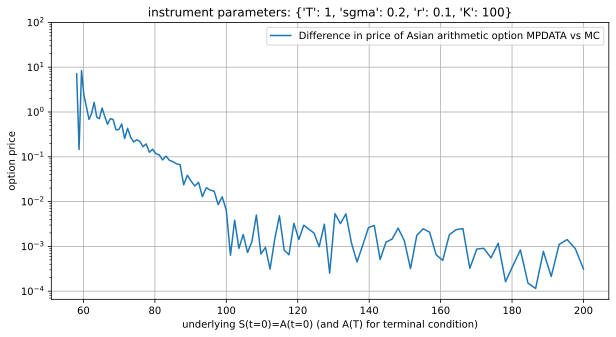

True price: 7.079
Numeric price: 7.096975058351778
MC price: 7.051676711641259


In [45]:
params = {
        'T': 1,
        'K': 100,
        'r': 0.1,
        'sgma': 0.2,
        'spot': 100,
        'true_price': 7.079,
    }
run_numeric_and_mc(params, nx=121, ny=200, nt=4000)

self.l2=np.float64(23.54930957348305)
CFL 0.05096569759303827
courant_x=np.float64(0.0011656975930382828), courant_y=np.float64(0.04979999999999998)
x_dim_advector.shape=(102, 250), self.a_dim_advector.shape=(101, 251)


IntProgress(value=0, max=5000)

MPDATA elapsed time: 76.43629837036133
Numeric price: 4.590857118265698


101it [03:28,  2.06s/it]

MC elapsed time: 208.16607403755188


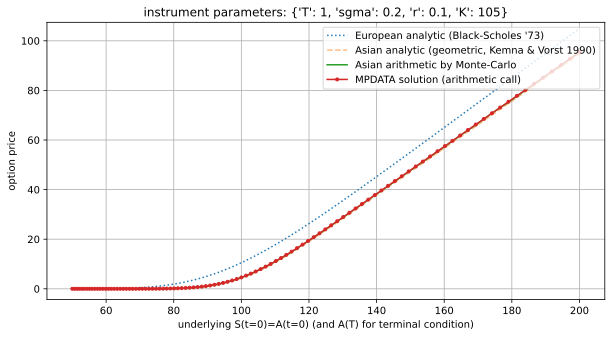

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:395: RuntimeWarning: divide by zero encountered in divide
  abs(arithmetic_by_mc - history[frame_index][:, 0]) / arithmetic_by_mc,
/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:404: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


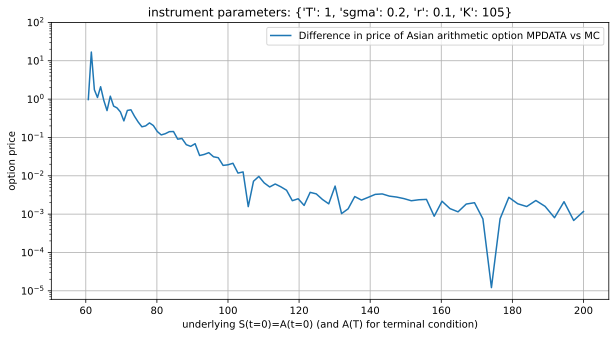

True price: 4.539
Numeric price: 4.590857118265698
MC price: 4.503736080266976


In [7]:
params = {
        'T': 1,
        'K': 105,
        'r': 0.1,
        'sgma': 0.2,
        'spot': 100,
        'true_price': 4.539,
    }
run_numeric_and_mc(params, nx=101, ny=250, nt=5000)

## sigma = 0.4

### T = 0.25

self.l2=np.float64(14.12958574408983)
CFL 0.09978809349927477
courant_x=np.float64(0.00012142683260815438), courant_y=np.float64(0.09966666666666661)
x_dim_advector.shape=(102, 300), self.a_dim_advector.shape=(101, 301)


IntProgress(value=0, max=3000)

MPDATA elapsed time: 54.102399826049805
Numeric price: 8.148219143453625


101it [04:27,  2.65s/it]

MC elapsed time: 267.14795303344727


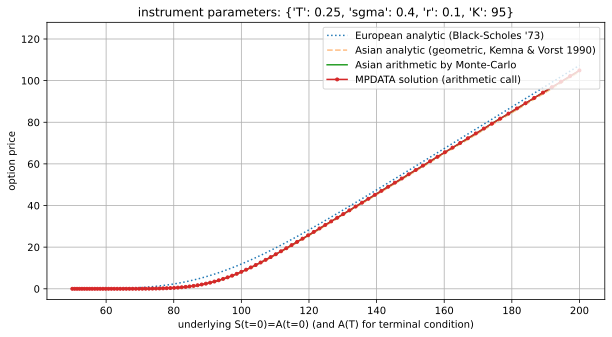

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:395: RuntimeWarning: divide by zero encountered in divide
  abs(arithmetic_by_mc - history[frame_index][:, 0]) / arithmetic_by_mc,
/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:404: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


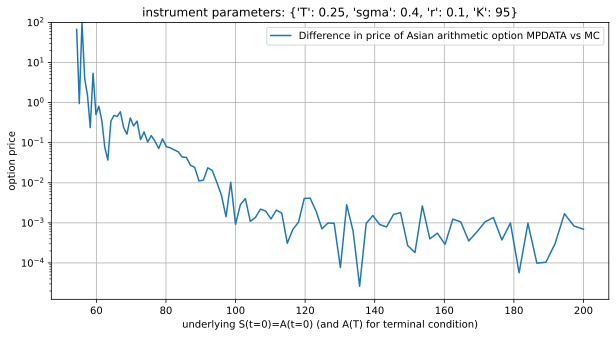

True price: 8.151
Numeric price: 8.148219143453625
MC price: 8.140743252725361


In [8]:
params = {
        'T': 0.25,
        'K': 95,
        'r': 0.1,
        'sgma': 0.4,
        'spot': 100,
        'true_price': 8.151,
    }
run_numeric_and_mc(params, nx=101, ny=300, nt=3000)

self.l2=np.float64(14.12958574408983)
CFL 0.06645476016594147
courant_x=np.float64(0.00012142683260815438), courant_y=np.float64(0.06633333333333331)
x_dim_advector.shape=(102, 200), self.a_dim_advector.shape=(101, 201)


IntProgress(value=0, max=3000)

MPDATA elapsed time: 73.67468810081482
Numeric price: 5.232699634724515


101it [03:28,  2.07s/it]

MC elapsed time: 208.96177792549133


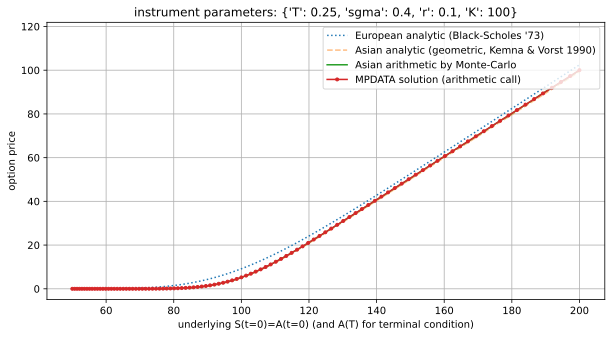

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:395: RuntimeWarning: divide by zero encountered in divide
  abs(arithmetic_by_mc - history[frame_index][:, 0]) / arithmetic_by_mc,
/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:404: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


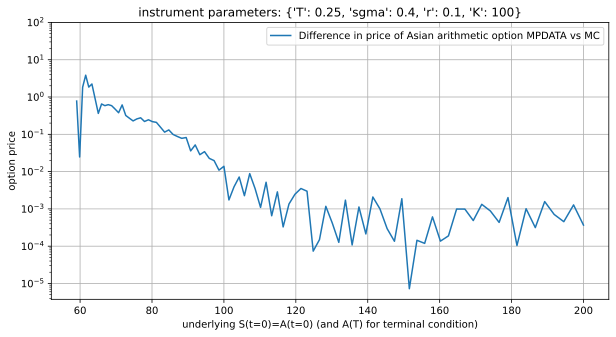

True price: 5.218
Numeric price: 5.232699634724515
MC price: 5.161130694728721


In [10]:
params = {
        'T': 0.25,
        'K': 100,
        'r': 0.1,
        'sgma': 0.4,
        'spot': 100,
        'true_price': 5.218,
    }
run_numeric_and_mc(params, nx=101, ny=200, nt=3000)

self.l2=np.float64(36.61431290338371)
CFL 0.039858429149155994
courant_x=np.float64(5.8429149156003e-05), courant_y=np.float64(0.03979999999999999)
x_dim_advector.shape=(82, 200), self.a_dim_advector.shape=(81, 201)


IntProgress(value=0, max=5000)

MPDATA elapsed time: 88.09815859794617
Numeric price: 3.156410250692144


81it [03:24,  2.52s/it]

MC elapsed time: 204.52555775642395


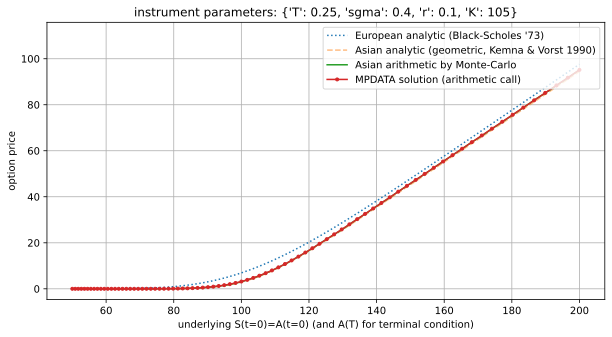

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:395: RuntimeWarning: divide by zero encountered in divide
  abs(arithmetic_by_mc - history[frame_index][:, 0]) / arithmetic_by_mc,
/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:404: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


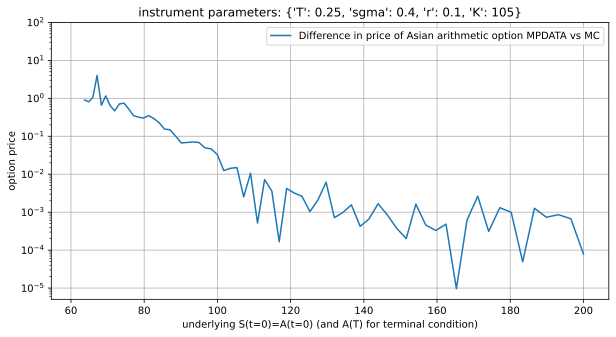

True price: 3.106
Numeric price: 3.156410250692144
MC price: 3.0561261961139525


In [19]:
params = {
        'T': 0.25,
        'K': 105,
        'r': 0.1,
        'sgma': 0.4,
        'spot': 100,
        'true_price': 3.106,
    }
run_numeric_and_mc(params, nx=81, ny=200, nt=5000)

### T = 0.5

self.l2=np.float64(18.307156451691856)
CFL 0.03991685829831199
courant_x=np.float64(0.000116858298312006), courant_y=np.float64(0.03979999999999999)
x_dim_advector.shape=(82, 200), self.a_dim_advector.shape=(81, 201)


IntProgress(value=0, max=5000)

MPDATA elapsed time: 124.03241348266602
Numeric price: 10.446123536926867


81it [03:36,  2.68s/it]

MC elapsed time: 216.9741814136505


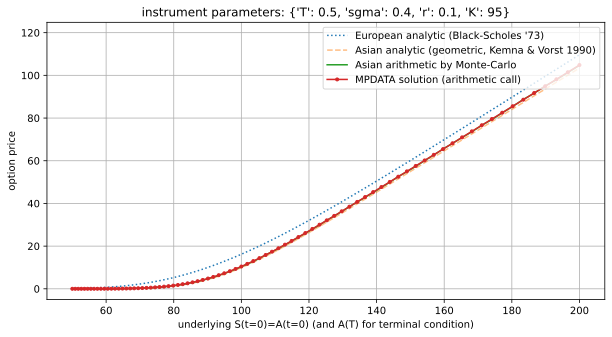

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:404: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


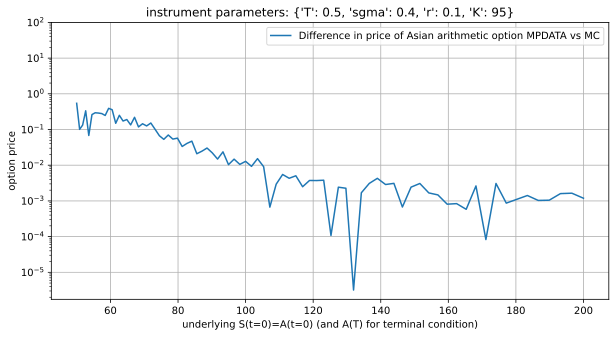

True price: 10.425
Numeric price: 10.446123536926867
MC price: 10.313906034050241


In [23]:
params = {
        'T': 0.5,
        'K': 95,
        'r': 0.1,
        'sgma': 0.4,
        'spot': 100,
        'true_price': 10.425,
    }
run_numeric_and_mc(params, nx=81, ny=200, nt=5000)

self.l2=np.float64(18.307156451691856)
CFL 0.03991685829831199
courant_x=np.float64(0.000116858298312006), courant_y=np.float64(0.03979999999999999)
x_dim_advector.shape=(82, 200), self.a_dim_advector.shape=(81, 201)


IntProgress(value=0, max=5000)

MPDATA elapsed time: 131.24387907981873
Numeric price: 7.68451177587822


81it [02:49,  2.10s/it]

MC elapsed time: 169.76302123069763


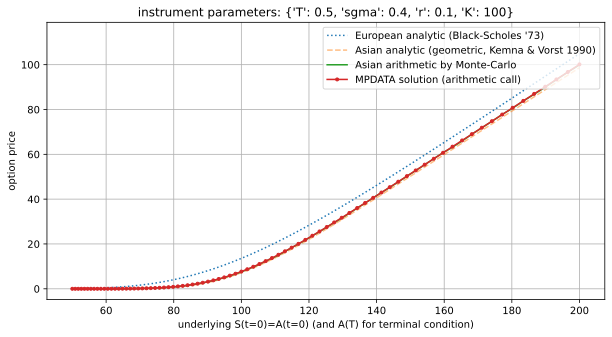

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:404: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


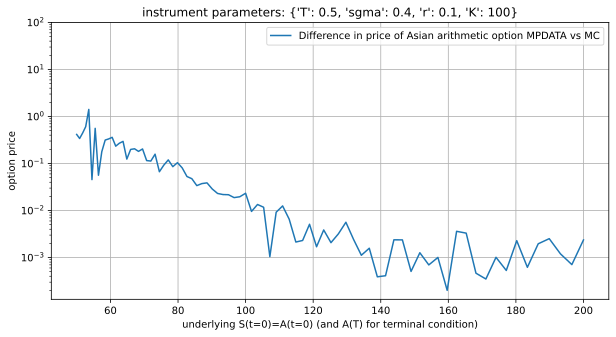

True price: 7.65
Numeric price: 7.68451177587822
MC price: 7.509663741280927


In [25]:
params = {
        'T': 0.5,
        'K': 100,
        'r': 0.1,
        'sgma': 0.4,
        'spot': 100,
        'true_price': 7.650,
    }
run_numeric_and_mc(params, nx=81, ny=200, nt=5000)

self.l2=np.float64(18.307156451691856)
CFL 0.02991685829831199
courant_x=np.float64(0.000116858298312006), courant_y=np.float64(0.029799999999999986)
x_dim_advector.shape=(82, 150), self.a_dim_advector.shape=(81, 151)


IntProgress(value=0, max=5000)

MPDATA elapsed time: 124.118656873703
Numeric price: 5.49905668963933


81it [02:53,  2.14s/it]

MC elapsed time: 173.67766666412354


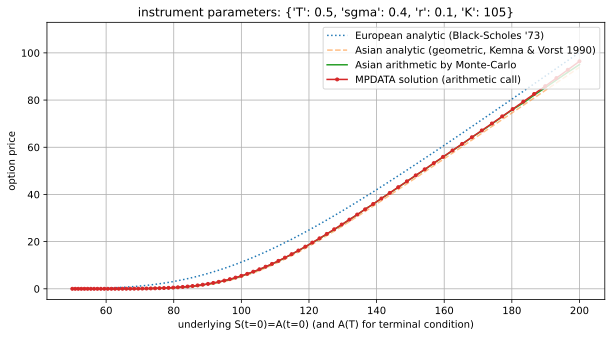

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:404: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


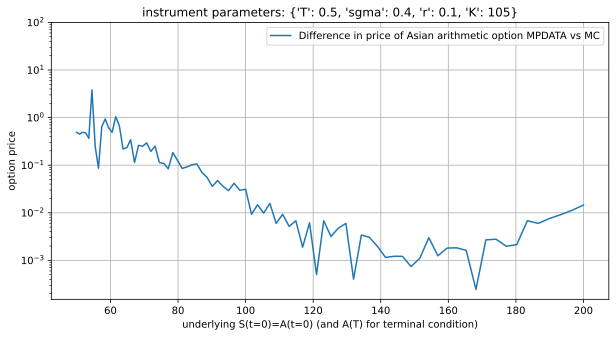

True price: 5.444
Numeric price: 5.49905668963933
MC price: 5.33228621554954


In [27]:
params = {
        'T': 0.5,
        'K': 105,
        'r': 0.1,
        'sgma': 0.4,
        'spot': 100,
        'true_price': 5.444,
    }
run_numeric_and_mc(params, nx=81, ny=150, nt=5000)

### T = 1

self.l2=np.float64(46.17964378298743)
CFL 0.005973577447085336
courant_x=np.float64(7.357744708533711e-05), courant_y=np.float64(0.005899999999999998)
x_dim_advector.shape=(52, 60), self.a_dim_advector.shape=(51, 61)


IntProgress(value=0, max=10000)

MPDATA elapsed time: 86.31910634040833
Numeric price: 13.981675844152802


51it [01:46,  2.09s/it]

MC elapsed time: 106.34066486358643


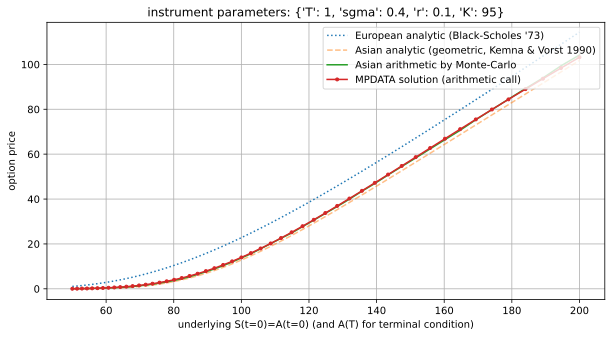

/home/pawel/PycharmProjects/PyMPDATA/examples/PyMPDATA_examples/Magnuszewski_et_al_2025/asian_option.py:404: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 100)


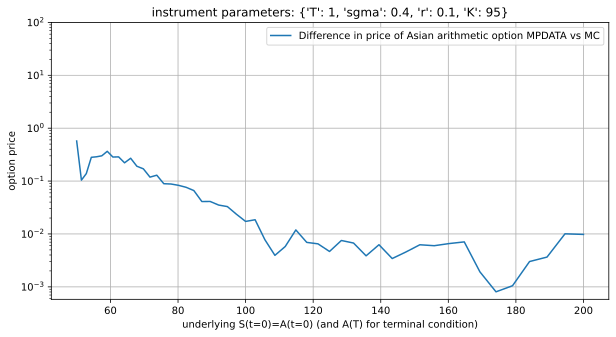

True price: 13.825
Numeric price: 13.981675844152802
MC price: 13.744524735698059


In [35]:
params = {
        'T': 1,
        'K': 95,
        'r': 0.1,
        'sgma': 0.4,
        'spot': 100,
        'true_price': 13.825,
    }
run_numeric_and_mc(params, nx=51, ny=60, nt=10000)

In [ ]:
params = {
        'T': 1,
        'K': 100,
        'r': 0.1,
        'sgma': 0.4,
        'spot': 100,
        'true_price': 11.213,
    }
run_numeric_and_mc(params, nx=81, ny=200, nt=5000)

In [ ]:
params = {
        'T': 1,
        'K': 105,
        'r': 0.1,
        'sgma': 0.4,
        'spot': 100,
        'true_price': 8.989,
    }
run_numeric_and_mc(params, nx=81, ny=200, nt=5000)